In [1]:
# Imports, always include this at the beginning

# No science without NumPy
import numpy as np

# Matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib notebook

# for pretty printing the model
from IPython.display import display, Markdown

# Of course we want Glotaran
import glotaran as gta

In [25]:
# Load the data
dataset_PAL_open = gta.io.TimeExplicitFile("data/PAL_700_ma_tr2_gain50_10uW_590nmfilter_21C_400nm_AV_bc_sh_sel_620_830.ascii").read("PALopen")
data_PAL_open = dataset_PAL_open.get()
time_axis_PAL_open = dataset_PAL_open.get_time_axis()
spectral_axis_PAL_open = dataset_PAL_open.get_spectral_axis()

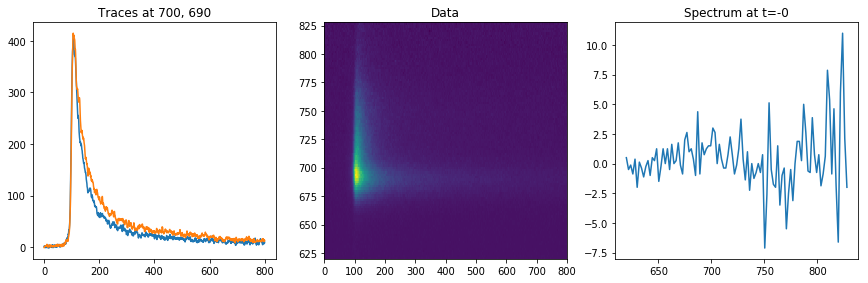

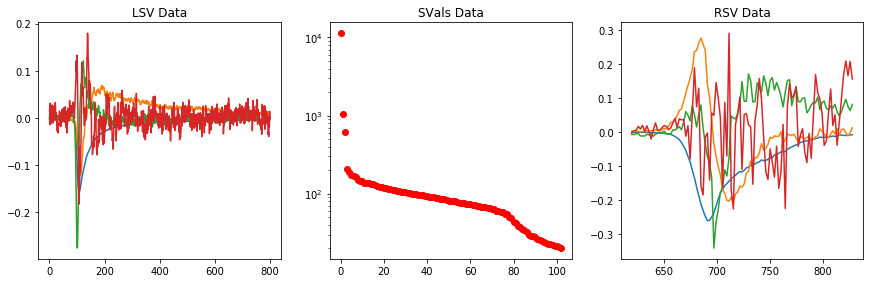

In [26]:
# Plot the Data

plt.figure(figsize=(20, 20))

# Plot some time traces
plt.subplot(4, 4, 1)
wl = [700, 690]
plt.title(f'Traces at {wl[0]}, {wl[1]}')
for w in wl:
    i = (np.abs(spectral_axis_PAL_open-w)).argmin()
    plt.plot(time_axis_PAL_open, data_PAL_open[i, :])

# Full Data
plt.subplot(4, 4, 2)
plt.title('Data')
plt.pcolormesh(time_axis_PAL_open, spectral_axis_PAL_open, data_PAL_open)

# Plot the spectrum at time=0
time_zero = 0
time_zero_idx = (np.abs(time_axis_PAL_open-time_zero)).argmin()
plt.subplot(4, 4, 3)
plt.title(f'Spectrum at t=-{time_zero}')
plt.plot(spectral_axis_PAL_open, data_PAL_open[:, time_zero_idx])


plt.figure(figsize=(20, 20))

lsvd, svals, rsvd = dataset_PAL_open.svd()

# Plot left singular vectors (LSV, times, first 4)
plt.subplot(4, 4, 1)
plt.title('LSV Data')
for i in range(4):
    plt.plot(time_axis_PAL_open, lsvd[:, i])

# Plot singular values (SV)
plt.subplot(4, 4, 2)
plt.title('SVals Data')
plt.plot(range(max(10, min(len(time_axis_PAL_open), len(spectral_axis_PAL_open)))), svals, 'ro')
plt.yscale('log')

# Plot right singular vectors (RSV, wavelengths, first 4)
plt.subplot(4, 4, 3)
plt.title('RSV Data')
for i in range(4):
    plt.plot(spectral_axis_PAL_open, rsvd[:, i])

In [30]:
# Then we can create our model

model_spec = '''
type: kinetic
parameters: 
  - initial_concentration:
    - [1, {vary: false}]
    - [0, {vary: false}]
    - [0, {vary: false}]
    - [0, {vary: false}]
  - irf:
    - ["center", 101]
    - ["width", 4.5]
  - k:
    - 0.3
    - 0.04
    - 0.01
    - 0.002

      
compartments: [s1, s2, s3, s4]

megacomplexes:
    - label: mc1
      k_matrices: [km1]
      
k_matrices:
  - label: "km1"
    matrix: {
      '("s2","s1")': k.1,
      '("s3","s2")': k.2,
      '("s4","s3")': k.3,
      '("s4","s4")': k.4
    }
    
irf:
  - label: irf
    type: gaussian
    center: irf.center
    width: irf.width

initial_concentration: #equal to the total number of compartments
  - label: inputD1
    parameter: [initial_concentration.1, initial_concentration.2, initial_concentration.3, initial_concentration.4] 
    
datasets:
  - label: PALopen
    type: spectral
    initial_concentration: inputD1
    megacomplexes: [mc1]
    irf: irf
'''

model = gta.parse(model_spec)
model.set_dataset("PALopen", dataset_PAL_open)
# print(model)
display(Markdown(str(model)))

# Model

_Type_: Kinetic

## Parameter
  * __initial_concentration__:
    * __1__: _Value_: 1.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
    * __2__: _Value_: 0.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
    * __3__: _Value_: 0.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
    * __4__: _Value_: 0.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
  * __irf__:
    * __center__: _Value_: 101.0, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __width__: _Value_: 4.5, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
  * __k__:
    * __1__: _Value_: 0.3, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __2__: _Value_: 0.04, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __3__: _Value_: 0.01, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __4__: _Value_: 0.002, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True


## Datasets

### _PALopen_

* _Dataset Scaling_: None
* _Initial Concentration_: inputD1
* _Megacomplexes_: ['mc1']
* _Megacomplex Scalings_: None
* _Irf_: irf

## Compartments

* s1
* s2
* s3
* s4

## Megacomplexes

### _mc1_
* _K-Matrices_: ['km1']


## Initital Concentrations

* __inputD1__: ['initial_concentration.1', 'initial_concentration.2', 'initial_concentration.3', 'initial_concentration.4']

## K-Matrices

### _km1_

compartment |    __s1__ |    __s2__ |    __s3__ |    __s4__ |
------------|-----------|-----------|-----------|-----------|
     __s1__ |           |           |           |           |
     __s2__ |       k.1 |           |           |           |
     __s3__ |           |       k.2 |           |           |
     __s4__ |           |           |       k.3 |       k.4 |

## IRFs

### _irf_
* _Type_: 'Gaussian'
* _Center_: ['irf.center']
* _Width_: ['irf.width']
* _Center Dispersion_: []
* _Width Dispersion_: []
* _Scale_: []
* _Nomalize_: True



In [31]:
result = model.fit()
display(Markdown(str(result)))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.2022e+05                                    3.08e+07    
       1              2         5.0428e+05      1.16e+05       9.23e-01       1.11e+07    
       2              3         4.9978e+05      4.50e+03       1.29e-01       3.33e+06    
       3              4         4.9931e+05      4.70e+02       1.22e-02       7.52e+05    
       4              5         4.9926e+05      4.79e+01       1.01e-02       1.62e+05    
       5              6         4.9926e+05      4.42e+00       5.57e-03       3.77e+04    
       6              7         4.9926e+05      5.62e-01       2.31e-03       1.27e+04    
       7              8         4.9926e+05      7.49e-02       9.26e-04       4.59e+03    
       8              9         4.9926e+05      1.00e-02       3.58e-04       1.68e+03    
       9             10         4.9926e+05      1.34e-03       1.35e-04       6.12e+02    

# Fitresult

Optimization Result            |            |
-------------------------------|------------|
 Number of residual evaluation |         13 |
           Number of variables |          6 |
          Number of datapoints |     105472 |
            Negrees of freedom |     105466 |
                    Chi Square |998516.747652 |
            Reduced Chi Square |   9.467665 |

## Best Fit Parameter

  * __initial__:
    * __concentration__:
      * __1__: _Value_: 1.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
      * __2__: _Value_: 0.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
      * __3__: _Value_: 0.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
      * __4__: _Value_: 0.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
  * __irf__:
    * __center__: _Value_: 100.00139324709541, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __width__: _Value_: 4.8887482273304474, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
  * __k__:
    * __1__: _Value_: 0.31488648392542634, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __2__: _Value_: 0.04375091342238011, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __3__: _Value_: 0.018033579087940316, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __4__: _Value_: 0.0024542654535587155, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True

